In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
import random
import math
from datetime import timedelta
from scipy import stats

In [2]:
hotelstotal = pd.read_csv('../../training_set_VU_DM.csv')

In [3]:
hotels = hotelstotal[1:20000]

hotelstotal.prop_log_historical_price.max()

# sns.countplot(x = "prop_log_historical_price", data = hotels)

6.21

In [4]:
hotelstotal.prop_location_score2.describe()

count    3.867999e+06
mean     1.303852e-01
std      1.594634e-01
min      0.000000e+00
25%      1.900000e-02
50%      6.900000e-02
75%      1.805000e-01
max      1.000000e+00
Name: prop_location_score2, dtype: float64

In [27]:
def categorize_date(df):
    
    df['date_time_split'] = pd.to_datetime(df['date_time'])
    df['srch_month'] = df['date_time_split'].dt.month
    df['srch_year'] = df['date_time_split'].dt.year
    df['srch_hour'] = df['date_time_split'].dt.hour

#     bins = [0, 6, 12, 18, 23]
#     labels = [0, 1, 2, 3]
#     df['srch_daytime'] = pd.cut(df['srch_hour'], bins = bins, labels = labels)
    
    df['booking_month'] = (df['date_time_split'] + df['srch_booking_window'].apply(pd.offsets.Day)).dt.month

    df = df.drop(['date_time', 'srch_hour'], axis=1)
    
    return df

def categorize_prop_review_score(df):
    
    df['prop_review_score'] = df['prop_review_score'].fillna(0)
    
    return df
    
def categorize_hist_starrating(df):
    
    df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(-0.5)
    
    bins = [-1, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    df['vis_star'] = pd.cut(df.visitor_hist_starrating, bins, labels = labels)
    
    return df.drop(['visitor_hist_starrating'], axis=1)
#     return df
    
def categorize_hist_usd(df):
    df['vis_usd'] = pd.qcut(df['visitor_hist_adr_usd'], 4, labels = [1, 2, 3, 4])
    
    df['vis_usd'] = df['vis_usd'].cat.add_categories([0])
    df['vis_usd'] = df['vis_usd'].fillna(0)
    
    return df.drop(['visitor_hist_adr_usd'], axis=1)
#     return df
    
def categorize_prop_loc_score(df):
    
    df['prop_location_score1'] = df['prop_location_score1'].round()
    df['prop_location_score2'] = df['prop_location_score2'].fillna(df['prop_location_score2'].mean())
    df['prop_location_score2'] = df['prop_location_score2'].round(1)
    
    return df
    
def categorize_historical_price(df):
    
    df['prop_hist_price'] = pd.qcut(df['prop_log_historical_price'], 6, duplicates = 'drop', labels = [0, 1, 2, 3, 4, 5])
    
#     return df.drop(['prop_log_historical_price'], axis=1)
    return df
    
def categorize_price_usd(df):
    
    q = df['price_usd'].quantile(0.99)
    df['price_usd'] = df[df['price_usd'] < q]
    hotel_id = df.groupby(['prop_id'])
    df['price_usd'] = hotel_id.price_usd.apply(lambda x: x.fillna(x.mean()))
    
    df['cat_price_usd'] = pd.qcut(df['price_usd'], 6, labels = [0, 1, 2, 3, 4, 5])
    df['cat_price_usd'] = df['cat_price_usd'].fillna(5)
    
    return df

def categorize_gross_bookings_usd(df):
    
    df['gross_price_difference'] = df['gross_bookings_usd'] - df['price_usd']
    df['gross_price_difference'] = pd.qcut(df['gross_price_difference'], 4, labels = [1, 2, 3, 4])
    df['gross_price_difference'] = df['gross_price_difference'].cat.add_categories([0])
    df['gross_price_difference'] = df['gross_price_difference'].fillna(0)
    
    return df.drop(['gross_bookings_usd', 'price_usd'], axis=1)
    
def categorize_nights(df):
    
    df['srch_length_of_stay'] = np.where(df['srch_length_of_stay'] > 4, 5, df['srch_length_of_stay'])
    return df
    
def categorize_booking_window(df):
    
    df['srch_booking_window'] = df['srch_booking_window']/7
    df['srch_booking_window'] = df['srch_booking_window'].round(0).astype(int)
    df['srch_booking_window'] = np.where(df['srch_booking_window'] > 12, 12, df['srch_booking_window'])
    
    return df
    
def categorize_srch_count(df):
    
    df['srch_adults_count'] = np.where(df['srch_adults_count'] > 3, 3, df['srch_adults_count'])
    df['srch_children_count'] = np.where(df['srch_children_count'] > 3, 3, df['srch_children_count'])
    df['srch_room_count'] = np.where(df['srch_room_count'] > 2, 2, df['srch_room_count'])
    return df
    
def categorize_log_probs(df):
    
    df['srch_query_affinity_score'] = pd.qcut(df['srch_query_affinity_score'], 4, duplicates = 'drop')
    df['srch_query_affinity_score'] = df['srch_query_affinity_score'].cat.add_categories([0])
    df['srch_query_affinity_score'] = df['srch_query_affinity_score'].fillna(0)
    return df
    
def categorize_distance_hotel(df):
    
    distgroup = df.groupby(["visitor_location_country_id", "prop_country_id"])
    
    df['orig_destination_distance'] = distgroup.orig_destination_distance.apply(lambda x: x.fillna(x.mean()))
    
#     df['orig_destination_distance'] = df['orig_destination_distance'].fillna()
    
    df['orig_destination_distance'] = pd.qcut(df['orig_destination_distance'], 6, labels = [1, 2, 3, 4, 5, 6])
    df['orig_destination_distance'] = df['orig_destination_distance'].cat.add_categories([0])
    df['orig_destination_distance'] = df['orig_destination_distance'].fillna(0)
    return df
    
def categorize_comp_rates(df):
    
    
    df['all_comp_rates'] = df[['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate','comp8_rate']].min(axis=1)
    df['all_comp_rates'] = df['all_comp_rates'].fillna(2)
    
    df.update(df[['comp1_rate', 'comp2_rate', 'comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']].fillna(0))
    
    df['count_comp_rates'] = df['comp1_rate'] + df['comp2_rate'] + df['comp3_rate'] + df['comp4_rate'] + df['comp5_rate'] + df['comp6_rate'] + df['comp7_rate'] + df['comp8_rate']
    df = df.drop(['comp1_rate', 'comp2_rate', 'comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate'], axis=1)
    return df
    
def categorize_comp_inv(df):
    
    df.update(df[['comp1_inv', 'comp2_inv', 'comp3_inv','comp4_inv','comp5_inv','comp6_inv','comp7_inv','comp8_inv']].fillna(0))
    
    df['count_comp_inv'] = df['comp1_inv'] + df['comp2_inv'] + df['comp3_inv'] + df['comp4_inv'] + df['comp5_inv'] + df['comp6_inv'] + df['comp7_inv'] + df['comp8_inv']
    df = df.drop(['comp1_inv', 'comp2_inv', 'comp3_inv','comp4_inv','comp5_inv','comp6_inv','comp7_inv','comp8_inv'], axis=1)
    return df
    
def categorize_comp_perc(df):
    
    df['comps_perc_diff'] = df[['comp1_rate_percent_diff', 'comp2_rate_percent_diff','comp3_rate_percent_diff','comp4_rate_percent_diff','comp5_rate_percent_diff','comp6_rate_percent_diff','comp7_rate_percent_diff','comp8_rate_percent_diff']].mean(axis=1)
    df['comps_perc_diff'] = pd.qcut(df['comps_perc_diff'], 4, labels = [1, 2, 3, 4])
    df['comps_perc_diff'] = df['comps_perc_diff'].cat.add_categories([0])
    df['comps_perc_diff'] = df['comps_perc_diff'].fillna(0)
    df = df.drop(['comp1_rate_percent_diff', 'comp2_rate_percent_diff','comp3_rate_percent_diff','comp4_rate_percent_diff','comp5_rate_percent_diff','comp6_rate_percent_diff','comp7_rate_percent_diff','comp8_rate_percent_diff'], axis=1)
    return df

In [28]:
pd.options.mode.chained_assignment = None  # default='warn'

hotels = hotelstotal[0:20000]

hotels = categorize_prop_review_score(hotels)
hotels = categorize_date(hotels)
hotels = categorize_hist_starrating(hotels)
hotels = categorize_hist_usd(hotels)
hotels = categorize_prop_loc_score(hotels)
hotels = categorize_historical_price(hotels)
hotels = categorize_price_usd(hotels)
hotels = categorize_gross_bookings_usd(hotels)
hotels = categorize_nights(hotels)
hotels = categorize_booking_window(hotels)
hotels = categorize_srch_count(hotels)
hotels = categorize_log_probs(hotels)
hotels = categorize_distance_hotel(hotels)
hotels = categorize_comp_rates(hotels)
hotels = categorize_comp_inv(hotels)
hotels = categorize_comp_perc(hotels)

C:\Users\tessa\Miniconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1129: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  .format(cls=type(self).__name__), PerformanceWarning)


In [22]:
hotels.isna().sum()

srch_id                        0
site_id                        0
visitor_location_country_id    0
prop_country_id                0
prop_id                        0
prop_starrating                0
prop_review_score              0
prop_brand_bool                0
prop_location_score1           0
prop_location_score2           0
prop_log_historical_price      0
position                       0
promotion_flag                 0
srch_destination_id            0
srch_length_of_stay            0
srch_booking_window            0
srch_adults_count              0
srch_children_count            0
srch_room_count                0
srch_saturday_night_bool       0
srch_query_affinity_score      0
orig_destination_distance      0
random_bool                    0
click_bool                     0
booking_bool                   0
date_time_split                0
srch_month                     0
srch_year                      0
booking_month                  0
vis_star                       0
vis_usd   

In [29]:
hotels["book_probability"] = 1 - (hotels["cat_price_usd"].astype(int) * (1/5))

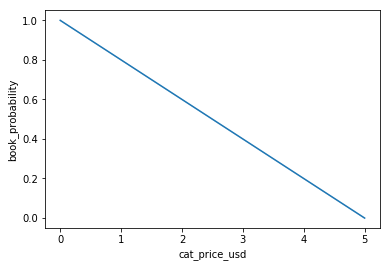

In [30]:
sns.lineplot(x = "cat_price_usd", y = "book_probability", data = hotels)